# Introduction

Machine Learning is a massive, massive suite of knowledge and at some point, I'd love to put a dent in that knowledge, really get to understanding how it works, the best way to solve problems, etc. Today, however, is not that day. Today, I'm doing a quick and dirty analysis of a dataset to gain a quick baseline of knowledge that will hopefully serve as a leg-up for future projects.

Everything in this blog post is contained in this GitHub repository. It's a Jupyter Notebook and the associated dataset. Unfortunately, the dataset is partitioned monthly and it's easier to use libraries to combine it than to manually do the work (big CSVs also tend to be a pain in the arse). This dataset is a Time Series of the [daily fuel price](https://www.fuelwatch.wa.gov.au/fuelwatch/pages/public/historicalFileDownloadRetail.jspx) in Western Australia. I found out part way through this analysis that Time Series are a little bit trickier to work with, but again, libraries make it fairly easy.

# First Steps

OK, preface aside, let's get into it! First up, we need to import some key libraries to assist our ML;

In [1]:
import glob         # File handling
import pandas as pd # Data structures and analytics

Excellent, now we can read in all the CSV files (feel free to grab more if you're interested). While we're at it, `pandas` can also help us combine them into a single dataset which will help with our analysis.

In [2]:
all_files = glob.glob("./*.csv")
data_frames = []

for file in all_files:
    df = pd.read_csv(file, index_col=None, header=0)
    data_frames.append(df)
    
df = pd.concat(data_frames, axis=0, ignore_index=True)

Now we have the data in a `pandas.DataFrame` structure, which is especially helpful for data analytics, machine learning, etc. There's a few more things we need to do to the `DataFrame` in order to make it even easier to work with.

In [3]:
df.set_index('PUBLISH_DATE', inplace=True)         # Set the index to be used for the data.
df.index = pd.to_datetime(df.index, dayfirst=True) # Convert the index to a proper datetime object.
df.sort_index(inplace=True)                        # Make sure the data is sorted (it *should* be, but it's best to be safe).
df.dropna()                                        # Drop any rows with missing/na values as they would make our life more difficult.
df.head()                                          # Check out what we've configured (top 5 rows, can pass a parameter to see more).

,TRADING_NAME,BRAND_DESCRIPTION,PRODUCT_DESCRIPTION,PRODUCT_PRICE,ADDRESS,LOCATION,POSTCODE,AREA_DESCRIPTION,REGION_DESCRIPTION,Unnamed: 10
PUBLISH_DATE,,,,,,,,,,
2018-10-01,53 Mile Roadhouse,United,ULP,148.9,31 South Western Hwy,PINJARRA,6208,Murray,Peel,NaN
2018-10-01,Coles Express Southern River,Coles Express,Diesel,165.9,216 Lakey St (Cnr Ranford Rd),SOUTHERN RIVER,6110,South of River,Metro,NaN
2018-10-01,Coles Express Southern River,Coles Express,98 RON,168.9,216 Lakey St (Cnr Ranford Rd),SOUTHERN RIVER,6110,South of River,Metro,NaN
2018-10-01,Coles Express Tarcoola,Coles Express,ULP,162.9,2 Fortyn Ct,GERALDTON,6530,Geraldton,Mid-West,NaN
2018-10-01,Coles Express Tarcoola,Coles Express,Diesel,167.9,2 Fortyn Ct,GERALDTON,6530,Geraldton,Mid-West,NaN


# Investigation

Before we go too far down the rabbit hole, let's have a look at the data we have and any patterns that we might be able to discern.

In [4]:
y = df.PRODUCT_PRICE       # Grab *just* the Product Price column
y.index.name = 'date'      # Rename the index
y = y.resample('D').mean() # Get the mean for each day
y.head()                   # Take a look at the results

date
2018-10-01    156.057514
2018-10-02    161.965962
2018-10-03    161.370760
2018-10-04    160.842148
2018-10-05    160.450753
Freq: D, Name: PRODUCT_PRICE, dtype: float64

Now we've simplified the data a bit (don't worry, it's just for investigative purposes, we still have the original `DataFrame` with multiple entries per day) let's see what it looks like.

Text(0, 0.5, 'Price')

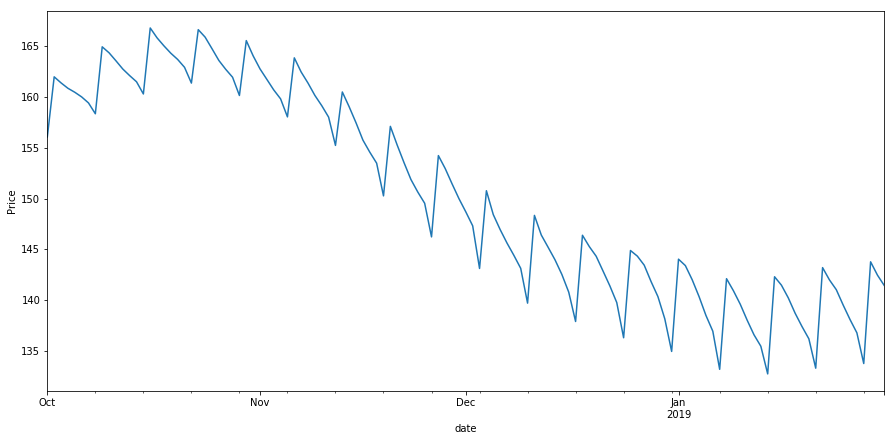

In [5]:
import matplotlib.pyplot as plt # Plots

# Automatically display the plot.
%matplotlib inline

plt.figure(figsize=(15,7))      # Make the plot a reasonable size, the default is a bit small. 
ax = y.plot()                   # Plot all the data in y.
ax.set_ylabel('Price')          # Make the Y-Axis label nicer.

Nice! There's definitely a pattern/trend in the data: There's a weekly low every Monday and a weekly high every Tuesday. There's possibly a larger monthly/yearly/seasonal trend in there too and if we had more data, we could probably confirm and even model for it, but that's outside the scope of this post.

Just to illustrate why we picked the mean of the price (average, median, etc. would have been equally useful), let's go back to the original dataset and see what that looks like.

Text(0, 0.5, 'Price')

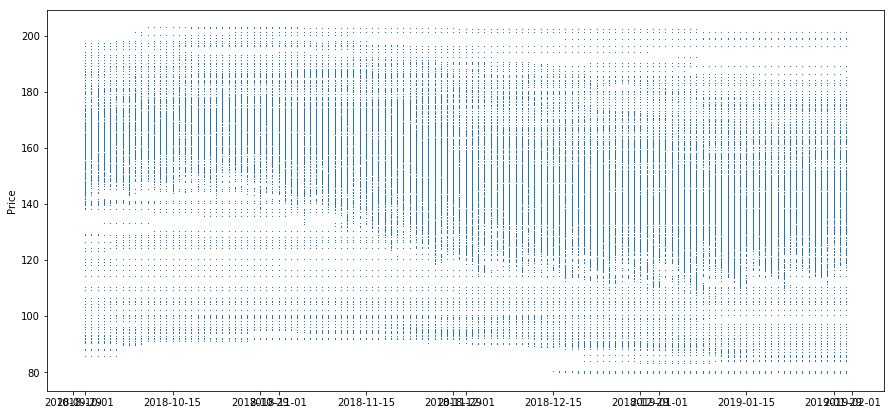

In [6]:
y2 = df.PRODUCT_PRICE.to_frame()
y2.columns = ['price']
plt.figure(figsize=(15,7))
plt.plot(y2.index, y2.price, ',') # ',' means "pixel" marker.
plt.ylabel('Price')

Woah. That's a lot of data. Not entirely unexpected though: There's approximately 2.5k entries per day. Some quick math puts that at about 75k - 77k per month! Not a massive dataset in the grand scheme of things, but not small either. Let's use some machine learning to help us to try and figure out a good approximation of the data.

# Simple Linear Regression

Linear regression is a bit of an odd one; My memory of high school and university math initially gave me the impression that linear regression refers to the line drawn through the data. The "linear" part actually refers to the relationship of the individual weights. For example; if we have a function y = a + bX + cX2 , "linear" refers to the relationship of a/b/c to X, even though the graph of this function is not a straight/linear line.

Now that we've cleared up that little misnomer, let's get onto the business of machine learning. First we've got some more imports that we need;

* NumPy - A scientific package which gives us access to mathematical functions.
* scikit-learn - A machine learning package.

In [7]:
import numpy as np
from sklearn.linear_model import LinearRegression

From here, we need to define "mean squared percentage error" as we'll be using that to calculate the accuracy of our linear regression model. There are other options, but this tends to be the most common. There's lots of technical definitions, but the basics of it boils to down this: 
    
  **The mean of all the squared errors between the predicted values and the actual values, in percentage form.**
    
MSE gives a higher penalty to bigger errors, which means that it'll be more obvious if our model is inaccurate.

In [22]:
# TODO: Change to Mean Squared Percentage Error (bigger penalties for bigger errors)
from sklearn.metrics import mean_squared_error

def mean_square_percentage_error(y_true, y_pred): 
    return np.mean(np.square((y_true - y_pred) / y_true)) * 100

Next, we need to have a quick chat about how we perform a train/test split for a Time Series dataset. It's important that we don't just take a random sampling of the data, otherwise the model will learn to predict the values in between two periods and over fit the model, which will cause it to have poor predictions for unknown data. Instead, we want to take the first 75% (or another percentage of your choosing) of the sequential data for training the model and leave the remaining 25% for testing the model. In this example, that means that we're taking Oct, Nov & Dec 2018 data for training, leaving Jan 2019 data for testing (very roughly speaking). Let's define a function to help us do this.

In [9]:
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size)) # The index to split data on.
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

That's it! We're ready to do some machine learning. This requires splitting the data into inputs (X) and outputs (y). The machine learning model is trained to use the input values to predict the known output values. Later, we can then use the model to try and predict unknown outputs, i.e. tomorrow's fuel price.

The date index cannot be handled by the `sklearn.LinearRegression` function. So let's do our first bit of [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering): Use the weekday instead of the date. To do this, we need to learn about something new; [One-Hot Encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

If we converted weekday to 0 - 6, then we'd end up with a single weight for weekday. Having a function `y = w_1 * Weekday` does not make sense. `w_1 * Monday` cannot possibly mean the same as `w_1 * Tuesday`. Instead, One-Hot Encoding gives us a "feature" for each Weekday, which in-turn gives us an associated weight; `y = w_1 * Monday + w_2 * Tuesday ...` makes a lot more sense! It looks like this;
![OneHotEncoding_Weekday](Images/OneHotEncoding.png)

TODO: Describe pipelines

In [44]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

df["weekday"] = df.index.weekday # Add a weekday column to use for One-Hot Encoding.

data = pd.DataFrame(df[["PRODUCT_PRICE", "weekday"]])
data.columns = ["price", "weekday"]

# Inputs
X = data.dropna().drop(['price'], axis=1)
# Outputs
y = data.dropna().price.to_frame()

# reserve 25% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.25)

# Define pipeline
pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(categories="auto"), ["weekday"])
    ), 
    LinearRegression())

# Train model
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('onehotencoder', OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True), ['weekday'])])), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

Wait, where's the pretty graph? Well, we haven't told it to plot anything yet, just build a model based on the inputs and outputs. Let's define another function that'll help us plot the results.

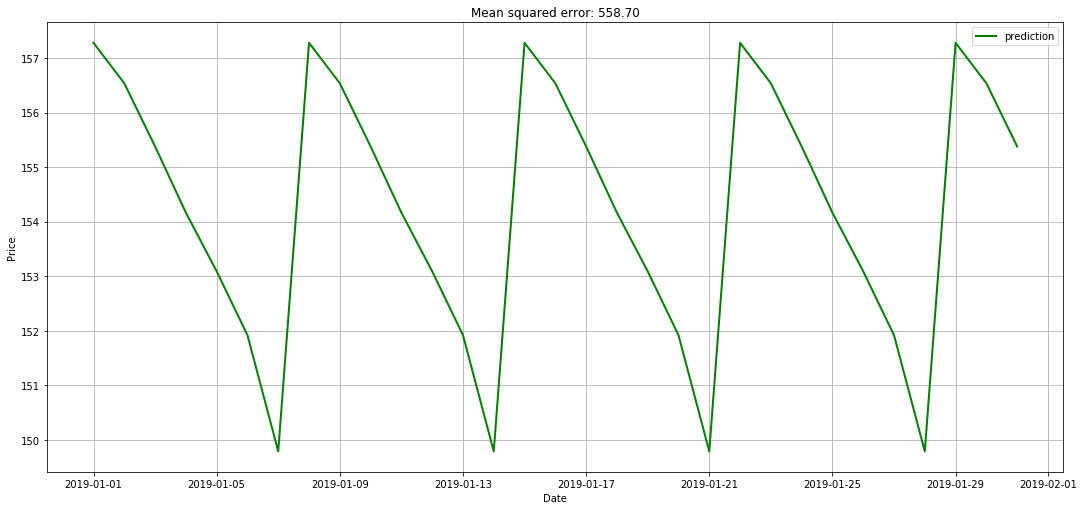

In [45]:
def plotModelResults(model, input_test, output_test, scatter=False):   
    predicted_values = model.predict(input_test) # Run the model against the test inputs.
    
    # Put it back into a DataFrame so it plots the values against time nicely. This is a Time Series after all.
    prediction = pd.DataFrame(input_test.index)
    prediction.set_index('date', inplace=True)
    prediction.index = pd.to_datetime(prediction.index, dayfirst=True)
    prediction["vals"] = predicted_values
    
    plt.figure(figsize=(15, 7))
    
    if scatter:
        plt.plot(prediction.index, prediction.vals, ".", label="prediction")
    else:
        plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    error = mean_squared_error(output_test.price, prediction.vals)
    plt.title("Mean squared error: {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    plt.ylabel("Price")
    plt.xlabel("Date")
    
plotModelResults(pipeline, X_test, y_test)

Well... It's not all bad! We're getting weekly minimums and maximums, like expected. It's just that there's not a whole lot of variance (`~149.5` - `~157.5`) compared to the actual data (`~75` to `~201`).

Honestly? Not too surprised with this initial result. The original dataset combines the prices of multiple fuel products, companies, locations and regions. To boil that all down to a simplistic equation is definitely too much to ask. Here's where the fun stuff comes in though! Let's see what other "features" we can add to the data in order to try and improve the model (I fully expect we can't come up with a decent model, I'll discuss it later. The process is the important part, so let's continue.) and reduce the mean absolute percentage error.

The obvious features to add would be "Product Type", "Region" and "Brand", so let's start with those.

In [39]:
data = pd.DataFrame(df[["PRODUCT_PRICE", "weekday", "PRODUCT_DESCRIPTION"]])
data.columns = ["price", "weekday", "type"]

Now we can extract the inputs and outputs and train a new model with the same code as before.

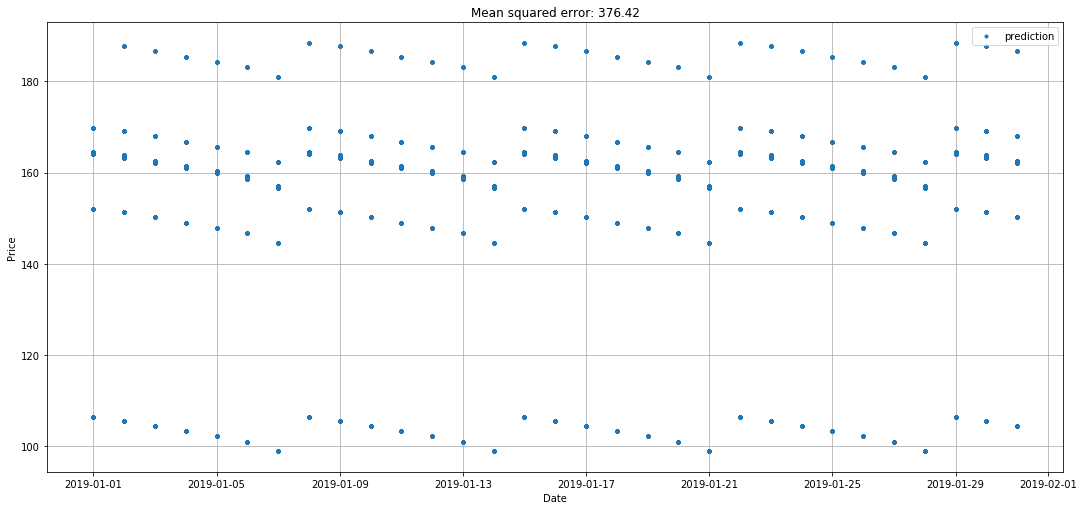

In [43]:
# Inputs
X = data.dropna().drop(["price"], axis=1)
# Outputs
y = data.dropna().price.to_frame()

# reserve 25% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.25)

# Define pipeline
pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(categories="auto"), ["weekday", "type"])
    ), 
    LinearRegression())

# Train model
pipeline.fit(X_train, y_train)

# Plot prediction
plotModelResults(pipeline, X_test, y_test, True)

Excellent! One extra feature has dropped the MSE by 32.63%, which is a good start. That's still a really high value for the MSE though, so let's keep going.

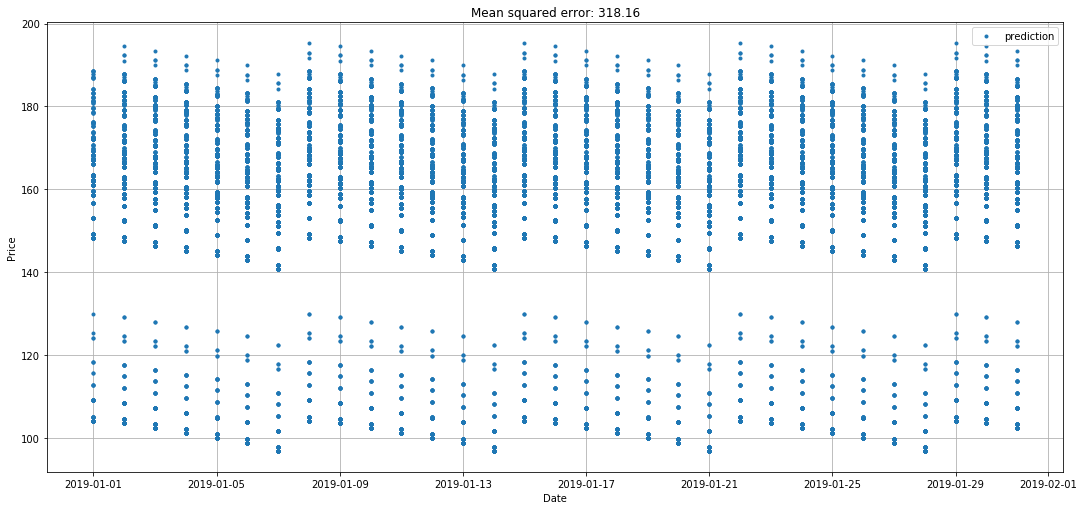

In [46]:
data = pd.DataFrame(df[["PRODUCT_PRICE", "weekday", "PRODUCT_DESCRIPTION", "REGION_DESCRIPTION"]])
data.columns = ["price", "weekday", "type", "region"]

# Inputs
X = data.dropna().drop(["price"], axis=1)
# Outputs
y = data.dropna().price.to_frame()

# reserve 25% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.25)

# Define pipeline
pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(categories="auto"), ["weekday", "type", "region"])
    ), 
    LinearRegression())

# Train model
pipeline.fit(X_train, y_train)

# Plot prediction
plotModelResults(pipeline, X_test, y_test, True)

15.48% improvement with the `region` feature, which is still significant.

In [47]:
data = pd.DataFrame(df[["PRODUCT_PRICE", "weekday", "PRODUCT_DESCRIPTION", "REGION_DESCRIPTION", "BRAND_DESCRIPTION"]])
data.columns = ["price", "weekday", "type", "region", "brand"]

# Inputs
X = data.dropna().drop(["price"], axis=1)
# Outputs
y = data.dropna().price.to_frame()

# reserve 25% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.25)

# Define pipeline
pipeline = make_pipeline(
    make_column_transformer(
        (OneHotEncoder(categories="auto"), ["weekday", "type", "region", "brand"])
    ), 
    LinearRegression())

# Train model
pipeline.fit(X_train, y_train)

# Plot prediction
plotModelResults(pipeline, X_test, y_test, True)

ValueError: Found unknown categories ['WA Fuels'] in column 3 during transform

Well... Bummer! Looking at the end of the stack trace, we can see the pipeline found an unknown category in the test data. Since the pipeline was never trained to encode the "WA Fuels" category, it can't encode it in the test data.

The simplest way to combat "unknowns" is to have a transform before encoding that groups similar items together. In this case, we'd write a transform that groups some of the smaller brands into an "Other" brand. This way, when a new brand comes along in the data, it'll get transformed to "Other" and then One-Hot Encoding will happily encode it, because it's already done that in the training dataset.

First up, let's have a look at the brands and see what we've go to work with.

In [92]:
import datetime
end_of_week = df.index.max()                             # Get the last date in our data set.
start_of_week = end_of_week - datetime.timedelta(days=6) # Get the date a week before.

groups = df.loc[start_of_week:end_of_week].groupby(["BRAND_DESCRIPTION"]).count() # Grab the last week of data, group by brand and count them.
target_groups = groups[groups.iloc[:,0] < 50].index.values
data_temp = pd.DataFrame(df[["PRODUCT_PRICE", "weekday", "PRODUCT_DESCRIPTION", "REGION_DESCRIPTION", "BRAND_DESCRIPTION"]])
data_temp.mask(in target_groups, "Other")
data_temp

SyntaxError: invalid syntax (<ipython-input-92-414eb6aa3e1b>, line 8)

There's a fairly big mix here and lots of opportunity to mess with the data, but let's keep things simple. "WA Fuels" is our "new" brand and it had 35 reported prices in 7 days. Some brands have even less than this, it even looks like there's a few brands that are actually just single fuel stations (brand is clearly a loose definition).

For all the brands under 100 reports in 7 days, 49 reports is the biggest, so let's use that as our threshold for now (we can change it later if needed). The better term here would be [hyperparameter](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)). The hyperparameter is distinct from the learned/trained parameters of the model, it is set before we do any training. In more advanced models, there may be a hyperparameter optimisation process which finds the hyperparameter(s) that provide the lowest MSE (or other loss indicator), but for now we'll stick with a manual process.

To use this hyperparameter, we're going to need to write our own transformer, much like the OneHotEncoder that we pass to the `make_column_transformer()` function in our pipeline. This new transformer will determine which brands to keep and which to rename to "Other", before doing the One-Hot encoding.

In [ ]:
class GroupedOneHotEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold
        
    def fit(self, df, *args):
        end_of_week = df.index.max()                             # Get the last date in our data set.
        start_of_week = end_of_week - datetime.timedelta(days=6) # Get the date a week before.

        groups = df.loc[start_of_week:end_of_week].groupby(["BRAND_DESCRIPTION"]).count() # Grab the last week of data, group by brand and count them.
        target_groups = groups[groups.iloc[:,0] < self.threshold].index.values
        
        df.mask(,"Other")